In [1]:
import setup

In [2]:
import numpy as np
import torch

from data.pixta_face_dataset import PIXTAFaceDataset

/home/qninhdt/miniconda3/envs/cctv-od/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = PIXTAFaceDataset('../datasets/pixta_face/', 'train')

In [4]:
dataset[0]

{'image': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'age': tensor([3], dtype=torch.int32),
 'gender': tensor([0], dtype=torch.int32),
 'race': tensor([0], dtype=torch.int32),
 'emotion': tensor([0], dtype=torch.int32),
 'masked': tensor([0], dtype=torch.int32),
 'skintone': tensor([1], dtype=torch.int32),
 'boxes': Boun

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageDraw
from PIL import ImageFont
from torchvision.transforms.functional import to_pil_image

def get_sample_image(sample):
    # convert torch tensor to PIL image
    image = to_pil_image(sample['image'])

    draw = ImageDraw.Draw(image)

    for i, box in enumerate(sample['boxes']):
        x, y, w, h = int(box[0]), int(box[1]), int(box[2]), int(box[3])

        color = 'red' if sample['gender'][i] == 0 else 'blue'

        draw.rectangle(((x, y), (x+w, y+h)), outline=color, width=2)

        age = dataset.categories['age'][int(sample['age'][i])]
        race = dataset.categories['race'][int(sample['race'][i])]
        emotion = dataset.categories['emotion'][int(sample['emotion'][i])]
        masked = dataset.categories['masked'][int(sample['masked'][i])]

        font = ImageFont.load_default(w/5)
        
        # Display text
        text = f"{age}\n{race}\n{emotion}\n{masked}"
        draw.text((x, y), text, fill="black", font=font)

    return image

In [6]:
import torchvision.transforms.v2 as T

In [7]:
from utils.transform import SquarePad, RandomCropWithoutLossingBoxes

IMAGE_SIZE = 640

transform = T.Compose([
    RandomCropWithoutLossingBoxes(),
    SquarePad(),
    T.RandomRotation(degrees=[-30, 30]),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomGrayscale(p=0.1),
    T.Resize(IMAGE_SIZE, antialias=True),
    T.ColorJitter(brightness=[0.5, 1.25]),
    T.RandomApply([
        T.GaussianBlur(kernel_size=(7, 7), sigma=(0.1, 2))
    ], p=0.5),
])

In [8]:
def visualize_sample(sample):
    # draw in 1x2 grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    ax1.imshow(get_sample_image(sample))
    ax1.set_title('Original')
    ax1.axis('off')

    transformed_sample = transform(sample)

    ax2.imshow(get_sample_image(transformed_sample))
    ax2.set_title('Transformed')
    ax2.axis('off')

    plt.show()

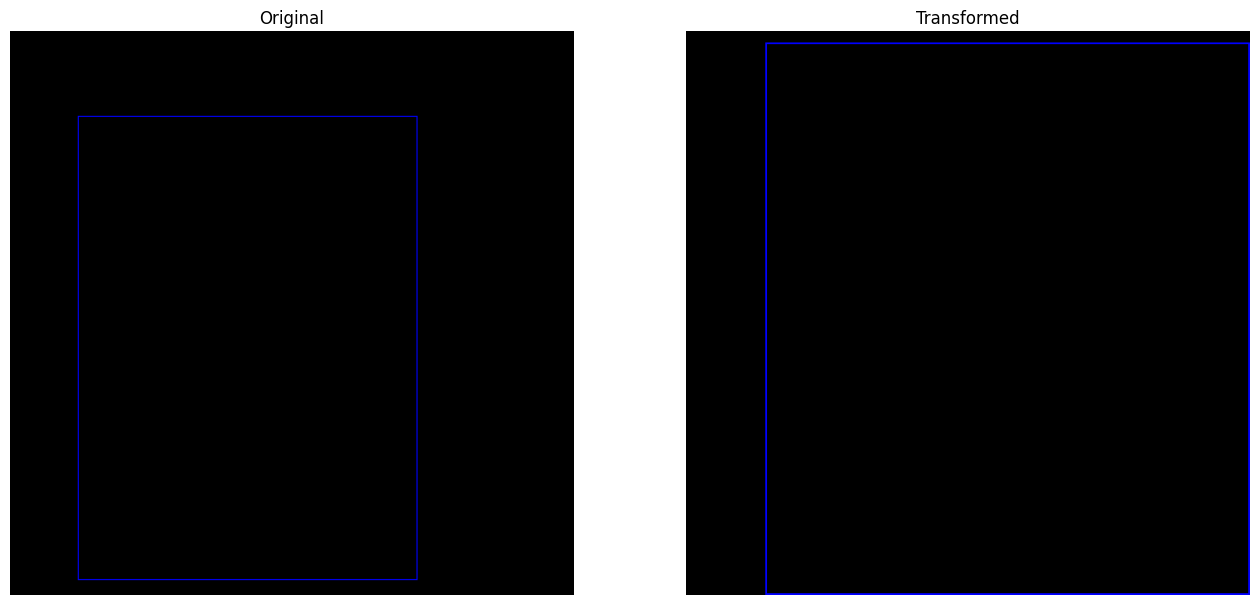

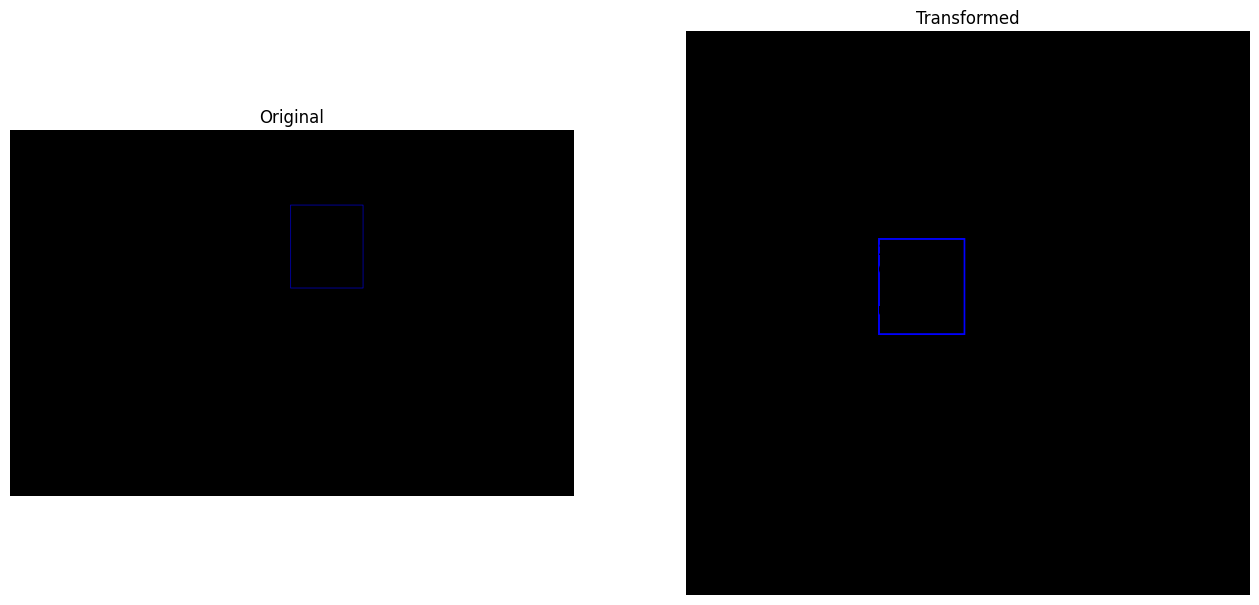

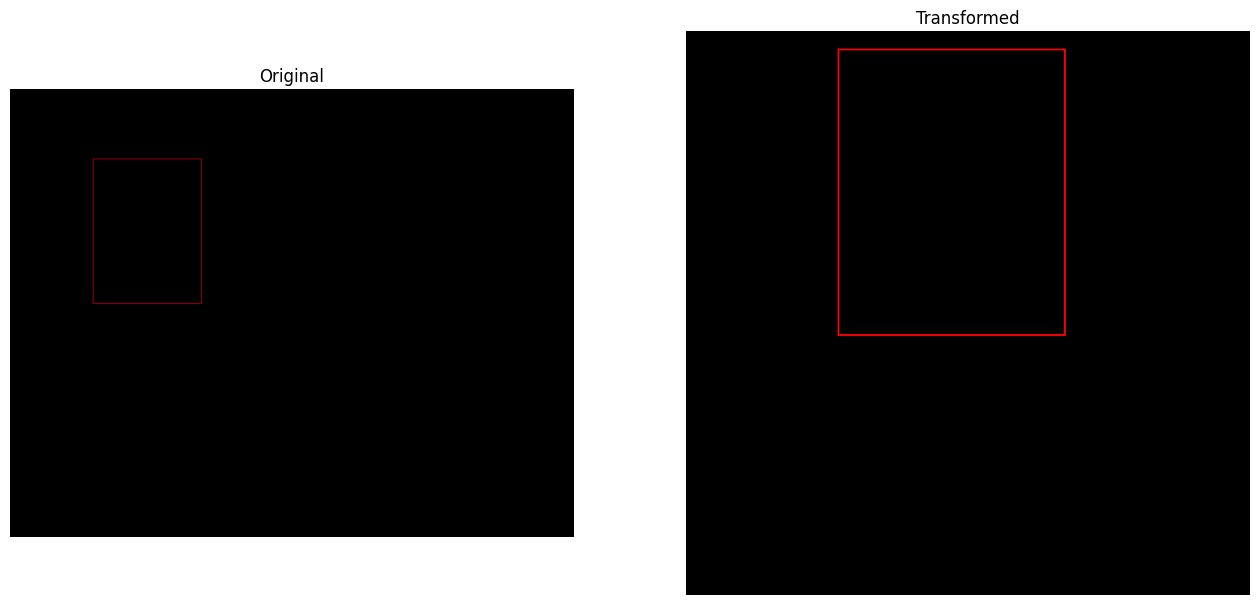

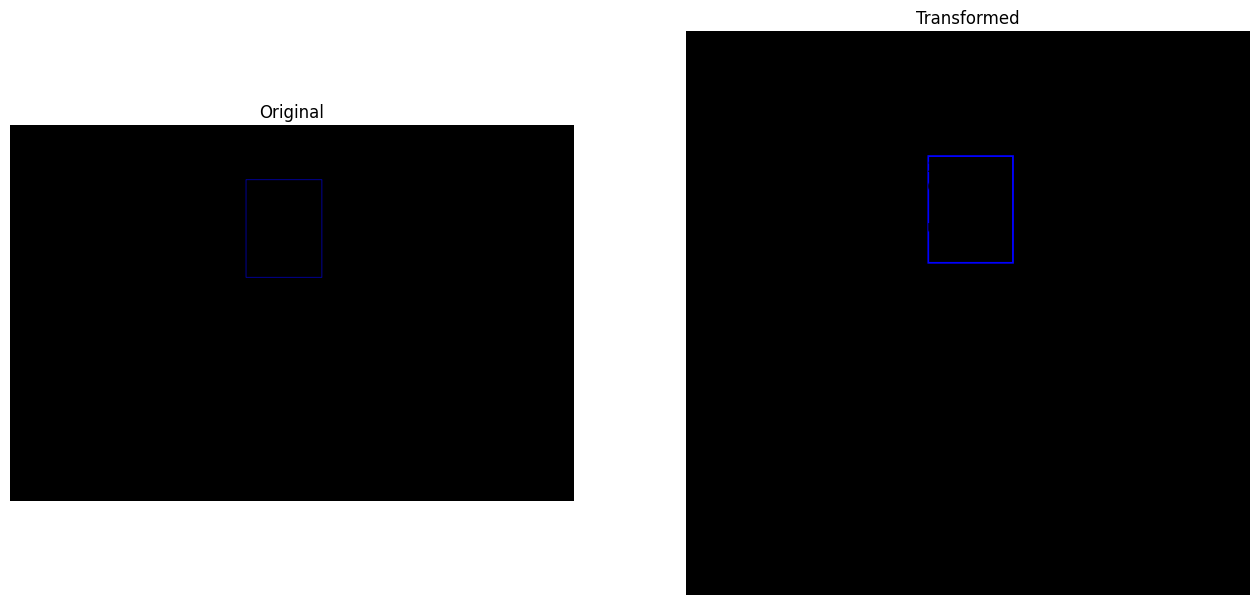

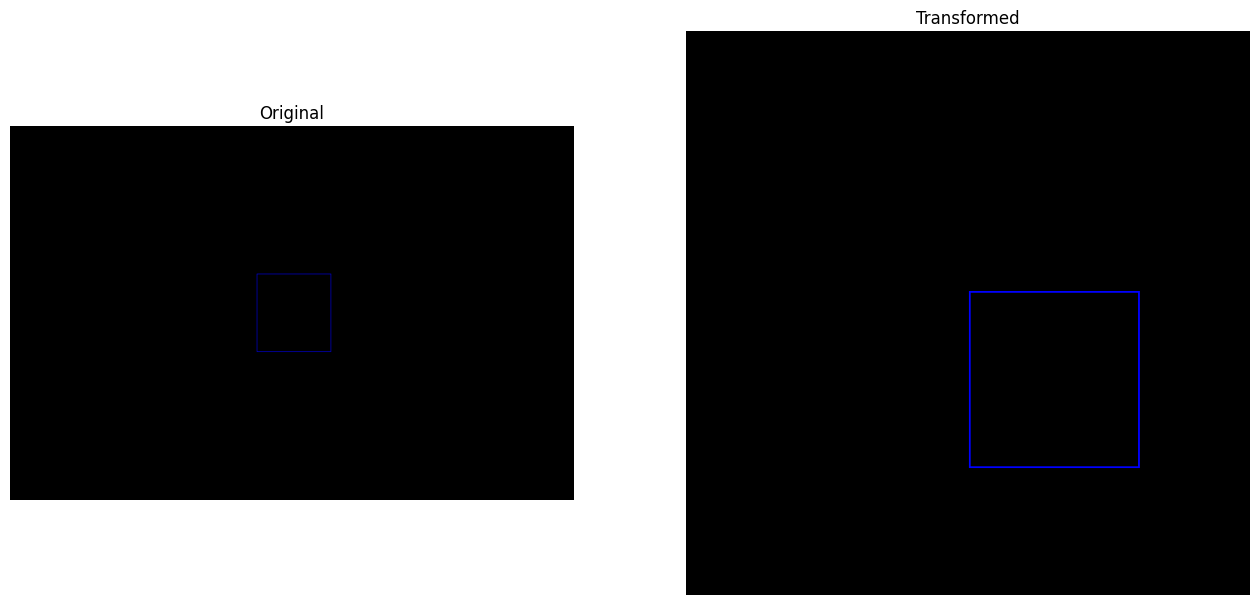

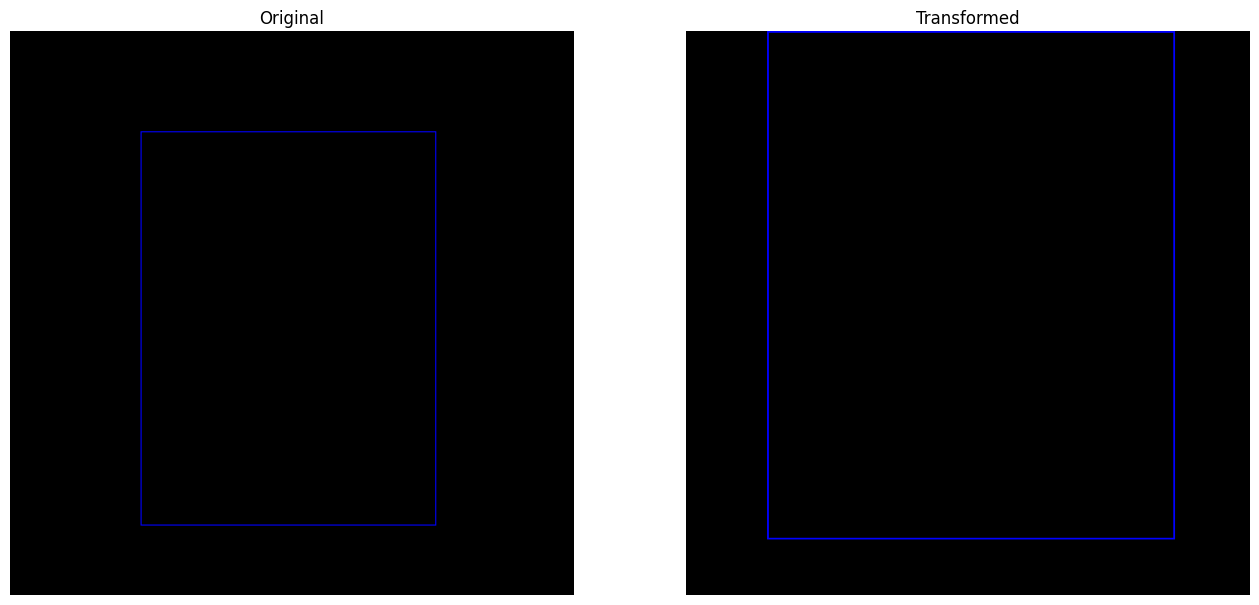

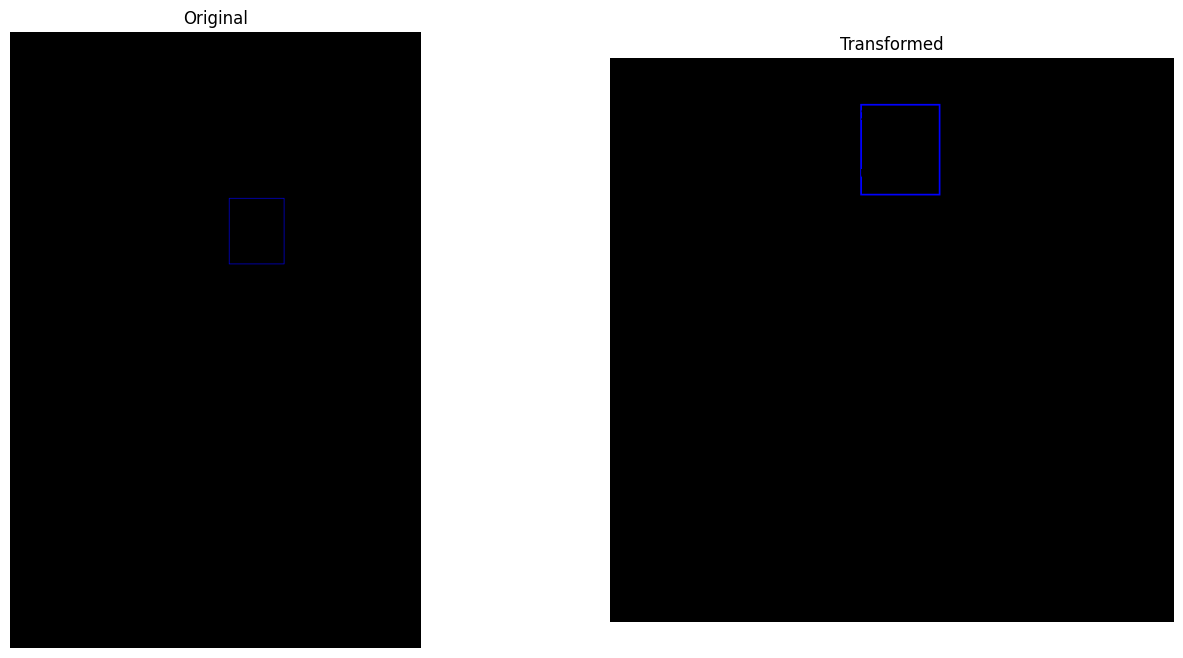

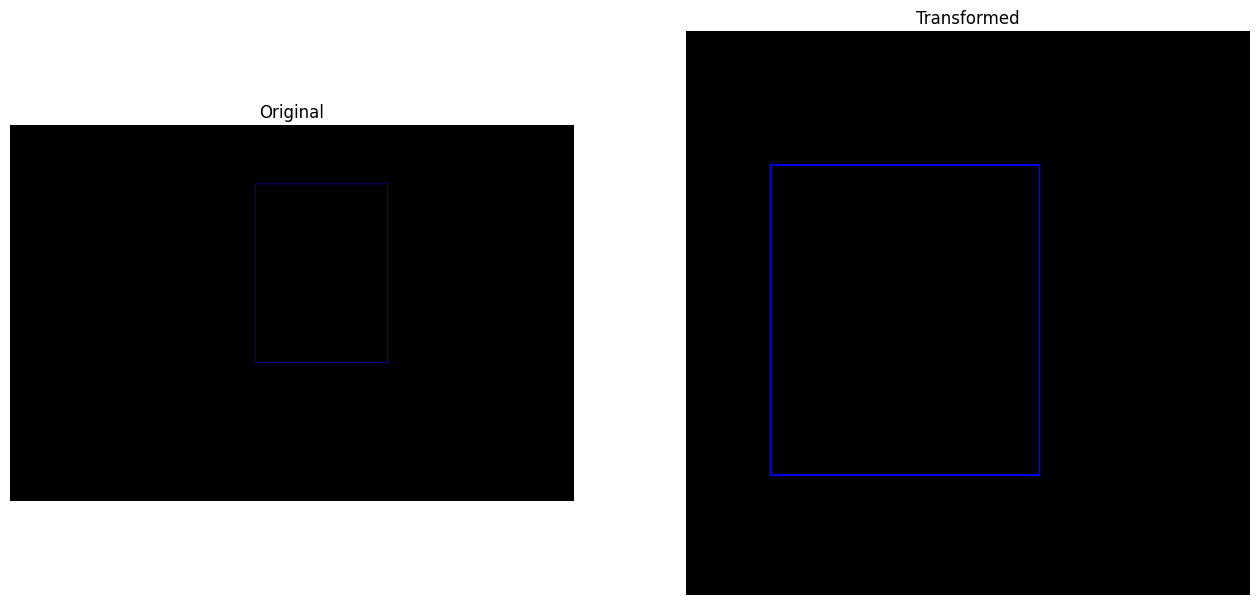

In [9]:
# visualize 8 random samples
for i in range(8):
    sample = dataset[np.random.randint(0, len(dataset))]
    visualize_sample(sample)

In [26]:
# load from json
import json

with open('../datasets/pixta_face/labels.json') as f:
    labels = json.load(f)

boxes = []
image_size = 640

for image in labels['images']:
    size = max(image['width'], image['height'])

    for face in image['faces']:
        w, h = face['box'][2], face['box'][3]

        w = w / size * image_size
        h = h / size * image_size

        boxes.append([w, h])

In [27]:
len(boxes)

15310

In [28]:

# use k-means to find good anchors
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9, random_state=0).fit(boxes)

/home/qninhdt/miniconda3/envs/cctv-od/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:

# sort by area  

areas = [w * h for w, h in kmeans.cluster_centers_]

sorted_indices = np.argsort(areas)

kmeans.cluster_centers_[sorted_indices]

array([[ 34.44557988,  45.16612649],
       [ 60.0376457 ,  77.70999654],
       [ 82.10919998, 106.58147123],
       [105.64149329, 136.52904791],
       [134.80728163, 173.21118832],
       [169.83143225, 219.19737724],
       [227.62241362, 289.76366259],
       [350.30724835, 467.29463868],
       [368.90204339, 510.40796567]])

In [33]:
# round to int
anchors = np.rint(kmeans.cluster_centers_[sorted_indices]).astype(np.int32)

anchors

array([[ 34,  45],
       [ 60,  78],
       [ 82, 107],
       [106, 137],
       [135, 173],
       [170, 219],
       [228, 290],
       [350, 467],
       [369, 510]], dtype=int32)

In [2]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

dataset = datasets.ImageFolder('../datasets/pixta_face',
                 transform=transforms.ToTensor())

loader = DataLoader(dataset,
                         batch_size=1,
                         num_workers=12,
                         shuffle=False)

/home/qninhdt/miniconda3/envs/cctv-od/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mean = 0.
std = 0.
n = 0

bar = tqdm(loader)
for images, _ in bar:
    nb = images.shape[0]
    images = images.view(nb, images.shape[1], -1)

    mean = n/(n+nb) * mean + nb/(n+nb) * images.mean(2).sum(0)
    std = n/(n+nb) * std + nb/(n+nb) * images.std(2).sum(0)

    bar.set_description(f"mean: {mean}, std: {std}")

    n += nb

mean: tensor([0.6596, 0.6235, 0.5875]), std: tensor([0.2272, 0.2248, 0.2345]): 100%|██████████| 25000/25000 [11:57<00:00, 34.82it/s]
